In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from numpy import sort
from sklearn.metrics import classification_report, roc_curve, roc_auc_score,confusion_matrix
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/network-intrusion-dataset/sampleSubmission.csv
/kaggle/input/network-intrusion-dataset/traindata.csv
/kaggle/input/network-intrusion-dataset/testdata.csv


# **Exploratory Data Analysis (EDA)**

In [3]:
train_data = pd.read_csv("../input/network-intrusion-dataset/traindata.csv")
test_data = pd.read_csv("../input/network-intrusion-dataset/testdata.csv")
train_data.head()

,ID,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,Class
0,0,0,tcp,http,SF,295,2584,0,0,0,...,1.00,0.00,0.01,0.03,0.0,0.0,0.00,0.01,21,0
1,1,0,tcp,http,SF,312,839,0,0,0,...,1.00,0.00,0.00,0.02,0.0,0.0,0.01,0.01,21,0
2,2,0,tcp,ftp,SF,1225,2451,0,0,0,...,0.45,0.02,0.00,0.00,0.0,0.0,0.00,0.00,11,1
3,3,0,tcp,http,SF,293,296,0,0,0,...,1.00,0.00,0.00,0.02,0.0,0.0,0.00,0.02,21,0
4,4,0,tcp,X11,REJ,0,0,0,0,0,...,0.01,0.03,0.01,0.00,0.0,0.0,0.01,1.00,11,0


In [4]:
test_data.head()

,ID,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
0,0,4,tcp,pop_3,SF,30,93,0,0,0,...,232,0.91,0.04,0.00,0.00,0.0,0.0,0.0,0.0,16
1,1,0,tcp,private,S0,0,0,0,0,0,...,5,0.02,0.08,0.00,0.00,1.0,1.0,0.0,0.0,21
2,2,0,udp,private,SF,52,54,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,17
3,3,0,tcp,http,SF,367,588,0,0,0,...,255,1.00,0.00,0.12,0.06,0.0,0.0,0.0,0.0,21
4,4,0,icmp,ecr_i,SF,1008,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,18


**Lets check for Nan Values**

In [5]:
if isinstance(train_data, pd.DataFrame):
        total_nan = train_data.isna().sum().sum()  # Calculate the total number of NaN (missing) values in the DataFrame
        print("Shape : %d rows, %d columns" % (train_data.shape[0], train_data.shape[1]))
        print("NA Values : %d " % (total_nan)) # Print the total number of NaN values
        print("%38s %10s     %10s %10s" % ("Column", "DataType", "unique elements", "NA Values"))
        col = train_data.columns
        dty = train_data.dtypes
        uni = train_data.nunique()
        na_val = train_data.isna().sum()
        for i in range(len(train_data.columns)):
            print("%38s %10s   %10s %10s" % (col[i], dty[i], uni[i], na_val[i]))
        

Shape : 23002 rows, 44 columns
NA Values : 0 
                                Column   DataType     unique elements  NA Values
                                    ID      int64        23002          0
                              duration      int64          702          0
                         protocol_type     object            3          0
                               service     object           66          0
                                  flag     object           11          0
                             src_bytes      int64         1578          0
                             dst_bytes      int64         3657          0
                                  land      int64            2          0
                        wrong_fragment      int64            3          0
                                urgent      int64            2          0
                                   hot      int64           20          0
                     num_failed_logins      int64          

In [6]:
if isinstance(test_data, pd.DataFrame):
        total_na = test_data.isna().sum().sum() # Calculate the total number of NaN (missing) values in the DataFrame
        print("Shape : %d rows, %d columns" % (test_data.shape[0], test_data.shape[1]))
        print("NA Values : %d " % (total_na)) # Print the total number of NaN values
        print("%38s %10s     %10s %10s" % ("Column", "DataType", "unique elements", "NA Values"))
        col = test_data.columns
        dty = test_data.dtypes
        uni = test_data.nunique()
        na_val = test_data.isna().sum()
        for i in range(len(test_data.columns)):
            print("%38s %10s   %10s %10s" % (col[i], dty[i], uni[i], na_val[i]))
        

Shape : 22501 rows, 43 columns
NA Values : 0 
                                Column   DataType     unique elements  NA Values
                                    ID      int64        22501          0
                              duration      int64          624          0
                         protocol_type     object            3          0
                               service     object           64          0
                                  flag     object           11          0
                             src_bytes      int64         1145          0
                             dst_bytes      int64         3645          0
                                  land      int64            2          0
                        wrong_fragment      int64            3          0
                                urgent      int64            4          0
                                   hot      int64           16          0
                     num_failed_logins      int64          

**Identify and Store Column names of Categorical Variables**

In [7]:
categorical_var = [i for i in train_data.columns if train_data[i].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical_var)))

print('The categorical variables are :\n\n', categorical_var)
print()
print(train_data[categorical_var].head())

There are 3 categorical variables

The categorical variables are :

 ['protocol_type', 'service', 'flag']

  protocol_type service flag
0           tcp    http   SF
1           tcp    http   SF
2           tcp     ftp   SF
3           tcp    http   SF
4           tcp     X11  REJ


In [8]:
# Identify and store column names of categorical variables in the 'test_data' DataFrame

categorical_var = [i for i in test_data.columns if test_data[i].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical_var)))

print('The categorical variables are :\n\n', categorical_var)
print()
print(test_data[categorical_var].head()) # Display the first few rows of the 'test_data' DataFrame with only the categorical variables
print()
print()
# Print the distribution of categorical variable values by frequency in 'train_data' and 'test_Data'
print('Distribution of Categorical variable values by frequency:\n')
for i in categorical_var: 
    print(train_data[i].value_counts())
    
print("--------------------------------------------------")
for i in categorical_var:
    print(test_data[i].value_counts())
    

There are 3 categorical variables

The categorical variables are :

 ['protocol_type', 'service', 'flag']

  protocol_type  service flag
0           tcp    pop_3   SF
1           tcp  private   S0
2           udp  private   SF
3           tcp     http   SF
4          icmp    ecr_i   SF


Distribution of Categorical variable values by frequency:

protocol_type
tcp     18740
udp      2725
icmp     1537
Name: count, dtype: int64
service
http         7124
private      4069
domain_u     1637
smtp         1313
ftp_data     1268
             ... 
urh_i           4
red_i           3
pm_dump         3
tim_i           1
http_8001       1
Name: count, Length: 66, dtype: int64
flag
SF        13471
S0         6566
REJ        2042
RSTR        462
RSTO        282
S1           81
SH           42
RSTOS0       20
S2           19
S3           13
OTH           4
Name: count, dtype: int64
--------------------------------------------------
protocol_type
tcp     18843
udp      2617
icmp     1041
Name: count,

## Data Visualization


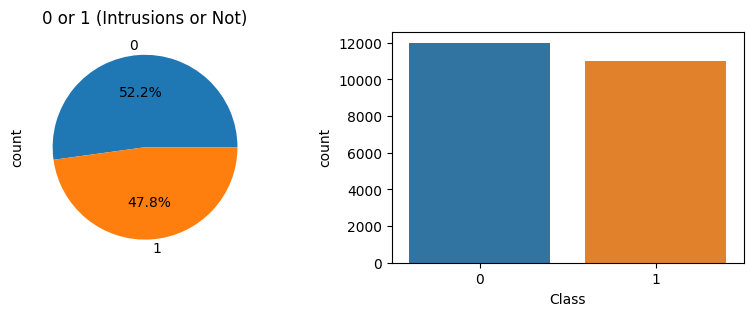

In [9]:
f,ax=plt.subplots(1,2,figsize=(10,3))

ax[0] = train_data['Class'].value_counts().plot.pie(explode=[0,0],autopct='%1.1f%%',ax=ax[0])
ax[0].set_title('0 or 1 (Intrusions or Not)')

sns.countplot(x=train_data['Class'])


plt.show()

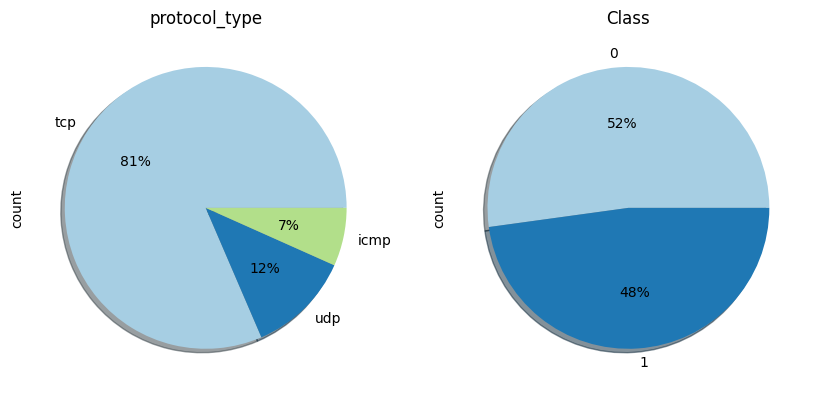

In [10]:
sns.set_palette('Paired')
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for ax, col in zip(axes.ravel(),['protocol_type', 'Class']):
    train_data[col].value_counts().plot(ax=ax, kind='pie', fontsize=10, autopct='%1.0f%%', shadow=True)
    ax.set_title(str(col), fontsize=12)
plt.show()

**Count of Protocol Types by Class**

Text(0.5, 1.0, 'Count of Protocol Types by Class')

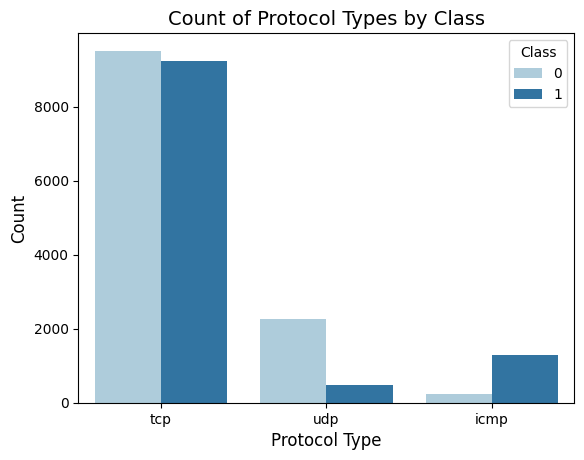

In [11]:
fig, ax = plt.subplots()

sns.countplot(data=train_data,x="protocol_type",hue='Class',palette='Paired')
ax.set_xlabel("Protocol Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

plt.legend(title="Class", loc='upper right')

plt.title("Count of Protocol Types by Class", fontsize=14)

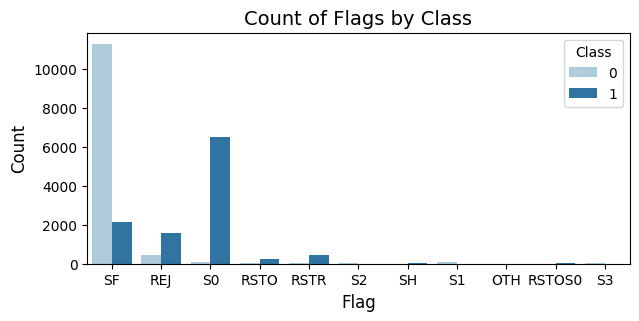

In [12]:
fig, ax = plt.subplots(figsize=(7, 3))

sns.countplot(data=train_data, x='flag', hue='Class', ax=ax,palette='Paired')

ax.set_xlabel("Flag", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

ax.legend(title="Class", loc='upper right')

ax.set_title("Count of Flags by Class", fontsize=14)

plt.show()

**Pie Charts for Categorical Variables**

In [13]:
import plotly.graph_objects as go

custom_color_scale = ['#1f77b4']
color_scale = custom_color_scale[:len(train_data['protocol_type'].unique())]

for f in ['protocol_type', 'service', 'flag']:
    val_counts = train_data[f].value_counts()
    fig = go.Figure()
    fig.add_trace(go.Pie(
        labels=val_counts.index,
        values=val_counts,
        marker=dict(colors=custom_color_scale)
    ))
    fig.update_traces(textposition='inside')
    fig.update_layout(
        title=f"Pie Chart of {f}",
    )
    fig.update_xaxes(title_text=f"{f}", title_font=dict(size=12))
    fig.update_yaxes(title_text="Count", title_font=dict(size=12))

    fig.show()

In [14]:
x_train = train_data.drop(columns={"Class","ID"})
y_train = train_data["Class"]
x_test = test_data.drop(columns={"ID"})

In [15]:
import category_encoders as ce
encoder = ce.OrdinalEncoder(cols=['protocol_type', 'service', 'flag'])

In [16]:
x_train = encoder.fit_transform(x_train)


In [17]:
x_test = encoder.transform(x_test)
x_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
0,0,1,1,1,295,2584,0,0,0,0,...,255,1.00,0.00,0.01,0.03,0.0,0.0,0.00,0.01,21
1,0,1,1,1,312,839,0,0,0,0,...,255,1.00,0.00,0.00,0.02,0.0,0.0,0.01,0.01,21
2,0,1,2,1,1225,2451,0,0,0,28,...,116,0.45,0.02,0.00,0.00,0.0,0.0,0.00,0.00,11
3,0,1,1,1,293,296,0,0,0,0,...,255,1.00,0.00,0.00,0.02,0.0,0.0,0.00,0.02,21
4,0,1,3,2,0,0,0,0,0,0,...,1,0.01,0.03,0.01,0.00,0.0,0.0,0.01,1.00,11


In [18]:
cols = x_train.columns

In [19]:
scaler = RobustScaler()

x_train = scaler.fit_transform(x_train)

x_test = scaler.transform(x_test)

In [20]:
x_train = pd.DataFrame(x_train, columns=[cols])
x_test = pd.DataFrame(x_test, columns=[cols])

<Axes: xlabel='None', ylabel='None'>

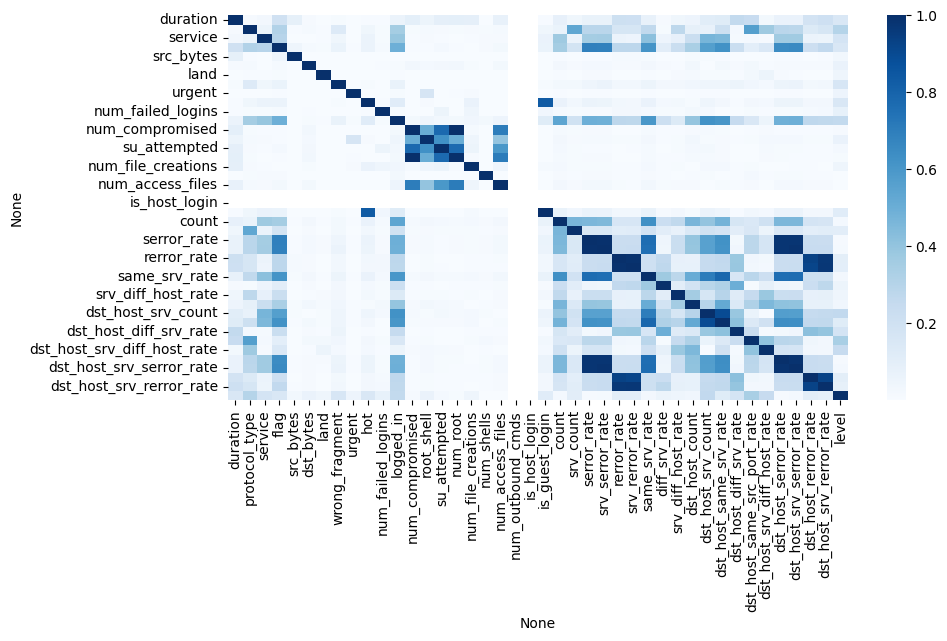

In [34]:
# Heatmap to visualize the absolute correlation matrix of the features in x_train
sns.heatmap(x_train.corr().apply(abs),cmap='Blues') 

<Axes: xlabel='None', ylabel='None'>

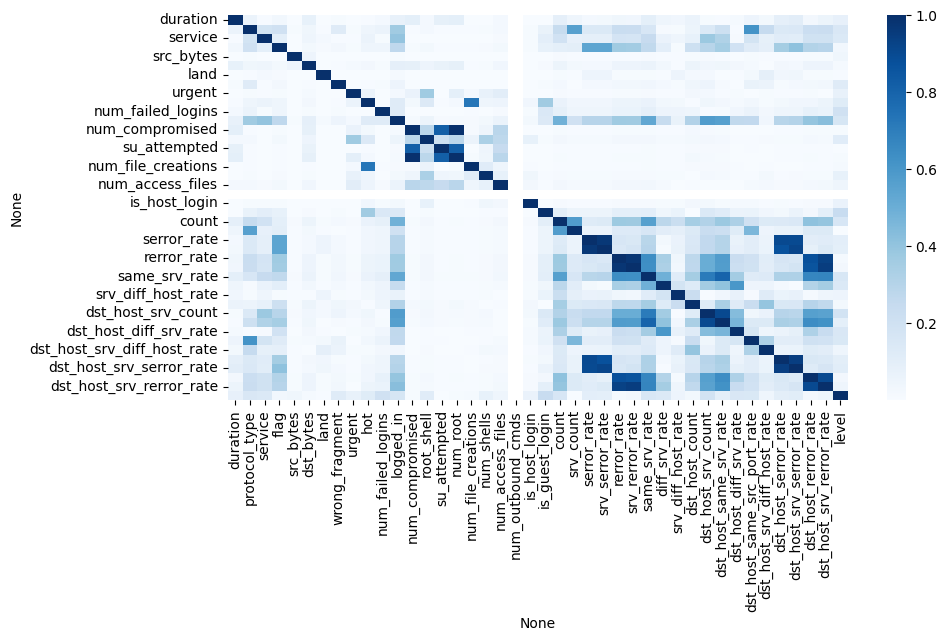

In [35]:
# Heatmap to visualize the absolute correlation matrix of the features in x_test
sns.heatmap(x_test.corr().apply(abs),cmap='Blues')

In [23]:
x_train.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
0,0.0,0.0,-0.1875,0.0,0.913558,5.316872,0.0,0.0,0.0,0.0,...,0.808163,0.568421,-0.428571,0.166667,3.0,0.0,0.0,0.00,0.01,0.333333
1,0.0,0.0,-0.1875,0.0,0.975432,1.726337,0.0,0.0,0.0,0.0,...,0.808163,0.568421,-0.428571,0.000000,2.0,0.0,0.0,0.01,0.01,0.333333
2,0.0,0.0,-0.1250,0.0,4.298453,5.043210,0.0,0.0,0.0,28.0,...,0.240816,-0.010526,-0.142857,0.000000,0.0,0.0,0.0,0.00,0.00,-3.000000
3,0.0,0.0,-0.1875,0.0,0.906278,0.609053,0.0,0.0,0.0,0.0,...,0.808163,0.568421,-0.428571,0.000000,2.0,0.0,0.0,0.00,0.02,0.333333
4,0.0,0.0,-0.0625,0.5,-0.160146,0.000000,0.0,0.0,0.0,0.0,...,-0.228571,-0.473684,0.000000,0.166667,0.0,0.0,0.0,0.01,1.00,-3.000000


In [24]:
x_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
0,4.0,0.0,0.6875,0.0,-0.050955,0.191358,0.0,0.0,0.0,0.0,...,0.714286,0.473684,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,-1.333333
1,0.0,0.0,0.0000,1.0,-0.160146,0.000000,0.0,0.0,0.0,0.0,...,-0.212245,-0.463158,0.714286,0.000000,0.0,1.0,1.0,0.0,0.0,0.333333
2,0.0,1.0,0.0000,0.0,0.029117,0.111111,0.0,0.0,0.0,0.0,...,0.808163,0.568421,-0.428571,16.666667,0.0,0.0,0.0,0.0,0.0,-1.000000
3,0.0,0.0,-0.1875,0.0,1.175614,1.209877,0.0,0.0,0.0,0.0,...,0.808163,0.568421,-0.428571,2.000000,6.0,0.0,0.0,0.0,0.0,0.333333
4,0.0,2.0,1.2500,0.0,3.508644,0.000000,0.0,0.0,0.0,0.0,...,0.808163,0.568421,-0.428571,16.666667,0.0,0.0,0.0,0.0,0.0,-0.666667


# Using Random Forest Classifier 

In [26]:
clf = RandomForestClassifier(random_state=20)
# model training 
clf.fit(x_train, y_train)

RandomForestClassifier(random_state=20)

In [28]:
pred_proba = clf.predict_proba(x_test)


In [29]:
pred=[]

for i in range(len(pred_proba)):
    if(pred_proba[i][0]>0.87):
        pred.append(0)
    else:
        pred.append(1)
np.count_nonzero(pred)

predictions = pd.DataFrame()
ypred = clf.predict(x_test)
predictions["ID"] = test_data['ID']
predictions["Class"] = pred
#just if you want to see this model 
# predictions.to_csv('RF_submission.csv', index=False, header=predictions.columns)
np.sum(predictions['Class'])

12812

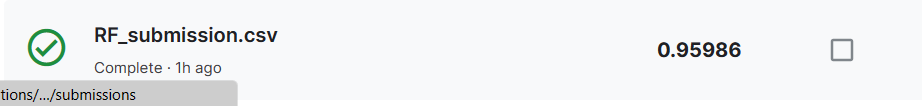

# Using XGBoost (Extreme Gradient Boosting) Classifier

In [30]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(x_train,y_train, test_size=0.2, random_state=42)

In [52]:

# Created an XGBoost classifier instance with logloss as the evaluation metric
base_model = XGBClassifier(eval_metric="logloss")

# Fit the base model to the training data
base_model.fit(x_train, y_train)

# Evaluate the base model on the test data
y_pred_base = base_model.predict(X_test_val)
predictions_base = [round(value) for value in y_pred_base]
accuracy_base = accuracy_score(y_test_val, predictions_base)
print("Base Model Accuracy: %.2f%%" % (accuracy_base * 100.0))

# Get feature importances from the base model
feature_importances = base_model.feature_importances_
# Sort feature importances in ascending order
thresholds = sorted(feature_importances)

# Iterate through different thresholds to select features
for thresh in thresholds:
    # Select features using the current threshold
    selection = SelectFromModel(base_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_val)
    
    # Train a model with the selected features
    selection_model = XGBClassifier(eval_metric="logloss")
    selection_model.fit(select_X_train, y_train_val)
    
    # Evaluate the model with the selected features on the test data
    select_X_test = selection.transform(X_test_val)
    y_pred_select = selection_model.predict(select_X_test)
    predictions_select = [round(value) for value in y_pred_select]
    accuracy_select = accuracy_score(y_test_val, predictions_select)
    
    # Print the results for different feature selection thresholds
    print("Threshold=%.3f, Selected Features=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy_select * 100.0))


Base Model Accuracy: 100.00%
Threshold=0.000, Selected Features=42, Accuracy: 99.93%
Threshold=0.000, Selected Features=42, Accuracy: 99.93%
Threshold=0.000, Selected Features=42, Accuracy: 99.93%
Threshold=0.000, Selected Features=42, Accuracy: 99.93%
Threshold=0.000, Selected Features=42, Accuracy: 99.93%
Threshold=0.000, Selected Features=42, Accuracy: 99.93%
Threshold=0.000, Selected Features=42, Accuracy: 99.93%
Threshold=0.000, Selected Features=42, Accuracy: 99.93%
Threshold=0.000, Selected Features=42, Accuracy: 99.93%
Threshold=0.000, Selected Features=42, Accuracy: 99.93%
Threshold=0.000, Selected Features=42, Accuracy: 99.93%
Threshold=0.000, Selected Features=42, Accuracy: 99.93%
Threshold=0.000, Selected Features=30, Accuracy: 99.93%
Threshold=0.002, Selected Features=29, Accuracy: 99.93%
Threshold=0.002, Selected Features=28, Accuracy: 99.96%
Threshold=0.002, Selected Features=27, Accuracy: 99.89%
Threshold=0.003, Selected Features=26, Accuracy: 99.87%
Threshold=0.004, Se

**Feature Importance**

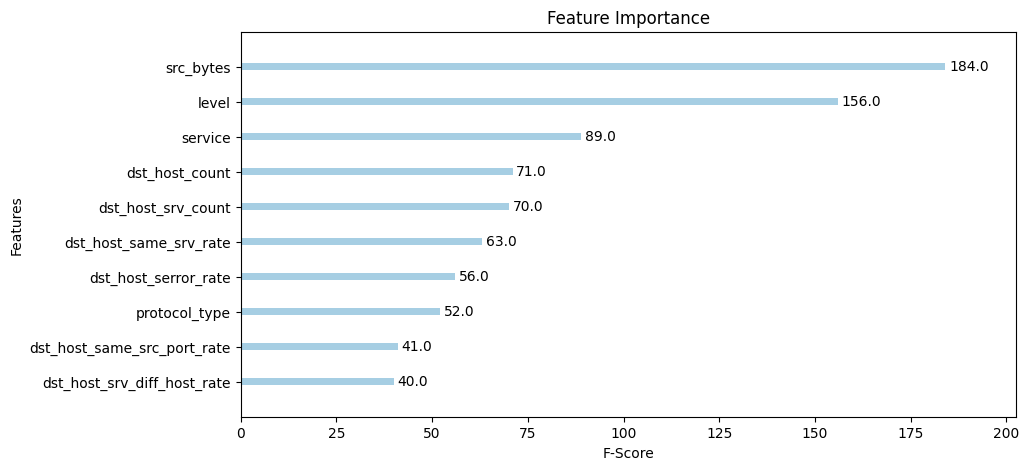

In [53]:
model = XGBClassifier()
model.fit(x_train, y_train)
plot_importance(model, max_num_features=10)

plt.rcParams["figure.figsize"] = (10, 5)  
plt.title("Feature Importance")
plt.xlabel("F-Score")
plt.ylabel("Features")
pyplot.set_cmap('Paired')

plt.grid(False)

plt.show()

In [55]:
# These hyperparameters define a search space for optimizing an XGBoost model using techniques like Bayesian optimization
space={'max_depth': hp.quniform("max_depth", 1, 40, 1),
        'gamma': hp.uniform ('gamma', 1,10),
        'reg_alpha' : hp.quniform('reg_alpha',40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'learning_rate' : hp.uniform('learning_rate', 0.01,0.1),
        'n_estimators': hp.quniform('n_estimators',1,500,1),
        'seed': 0
    }

In [56]:
def objective(space):
    """
    Optimize an XGBoost classifier with hyperparameters using Bayesian optimization.

    Parameters:
    space (dict): A dictionary containing hyperparameters to optimize.

    Returns:
    dict: A dictionary with 'loss' and 'status' to be used by the optimizer.
    """
    
    # Create an XGBoost classifier with the specified hyperparameters
    clf = xgb.XGBClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=space['colsample_bytree']
    )
    
    # Set up evaluation data for training and testing
    evaluation = [(X_train_val, y_train_val), (X_test_val, y_test_val)]
    
    # Fit the XGBoost classifier with the specified hyperparameters
    clf.fit(X_train_val, y_train_val,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10, verbose=False)
    
    # Make predictions on the test data and calculate accuracy
    pred = clf.predict(X_test_val)
    accuracy = accuracy_score(y_test_val, pred > 0.5)
    
    print("SCORE:", accuracy)
    
    # Define the 'loss' and 'status' for the optimizer
    return {'loss': -accuracy, 'status': STATUS_OK }


# Hyperparameter Optimization


In [ ]:
import warnings
warnings.filterwarnings('ignore')
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 500,
                        trials = trials)

SCORE:                                                 
0.9897848293849163                                     
SCORE:                                                                            
0.9908715496631167                                                                
SCORE:                                                                            
0.9910888937187567                                                                
SCORE:                                                                            
0.9895674853292763                                                                
SCORE:                                                                            
0.9876113888285155                                                                
SCORE:                                                                            
0.9904368615518365                                                                
SCORE:                                                    

**Best Hyperparameters**

In [58]:
print(best_hyperparams)


{'colsample_bytree': 0.9854999192734787, 'gamma': 1.8379437319550858, 'learning_rate': 0.017135938565350804, 'max_depth': 16.0, 'min_child_weight': 0.0, 'n_estimators': 358.0, 'reg_alpha': 40.0, 'reg_lambda': 0.7389808667035569}


In [59]:
params = {'colsample_bytree': 0.7226597411802128, 'gamma': 6.8303650411637165, 'learning_rate': 0.010018834311388431, 'max_depth': 28, 'min_child_weight': 4,
          'n_estimators': 91, 'reg_alpha': 42, 'reg_lambda': 0.22610147509152623}

In [60]:
xgb_clf = XGBClassifier(**params, eval_metric ="logloss", random_state = 845).fit(x_train,y_train)
pred = xgb_clf.predict(x_test)
pred_proba = xgb_clf.predict_proba(x_test)

In [61]:
preds=[]

for i in range(len(pred)):
    if(pred_proba[i][0]>0.75):
        preds.append(0)
    else:
        preds.append(1)

In [62]:
predictions = pd.DataFrame()
predictions["ID"] = test_data['ID']
predictions["Class"] = preds

predictions.to_csv('AryanGulati.csv', index=False, header=predictions.columns)

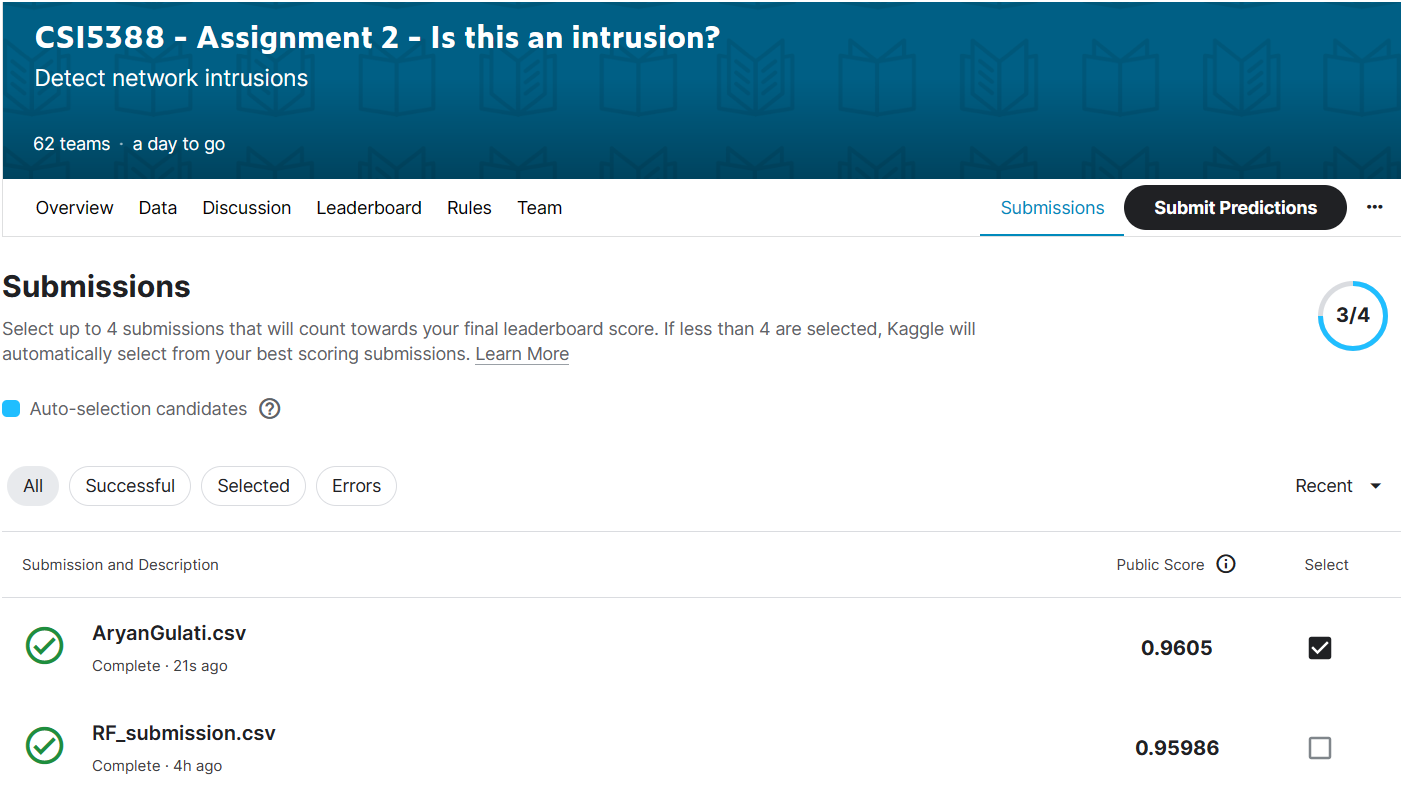

In [63]:
predictions


,ID,Class
0,0,1
1,1,1
2,2,0
3,3,0
4,4,1
...,...,...
22496,22496,0
22497,22497,1
22498,22498,1
22499,22499,0


Accuracy: 99.24%


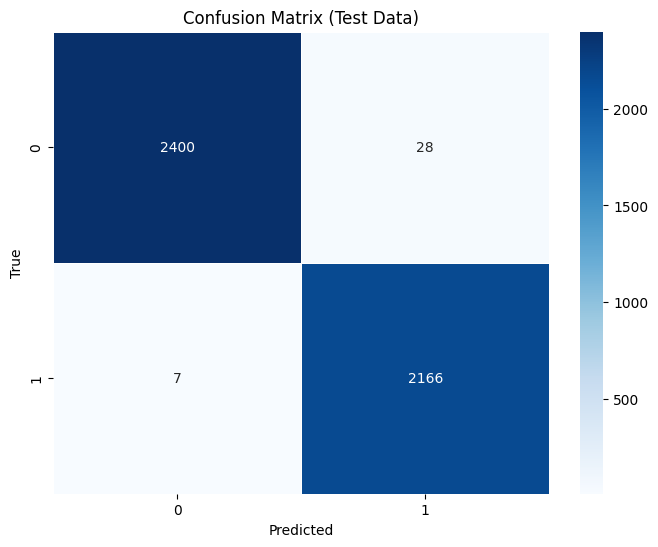

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      2428
           1       0.99      1.00      0.99      2173

    accuracy                           0.99      4601
   macro avg       0.99      0.99      0.99      4601
weighted avg       0.99      0.99      0.99      4601



In [64]:
# Predictions for test data and evaluate
y_pred = xgb_clf.predict(X_test_val)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# confusion matrix for the test data
confusion_mat = confusion_matrix(y_test_val, predictions)
# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Data)')
plt.show()
# Classification Report
classification_rep = classification_report(y_test_val, predictions)
print("Classification Report:\n", classification_rep)

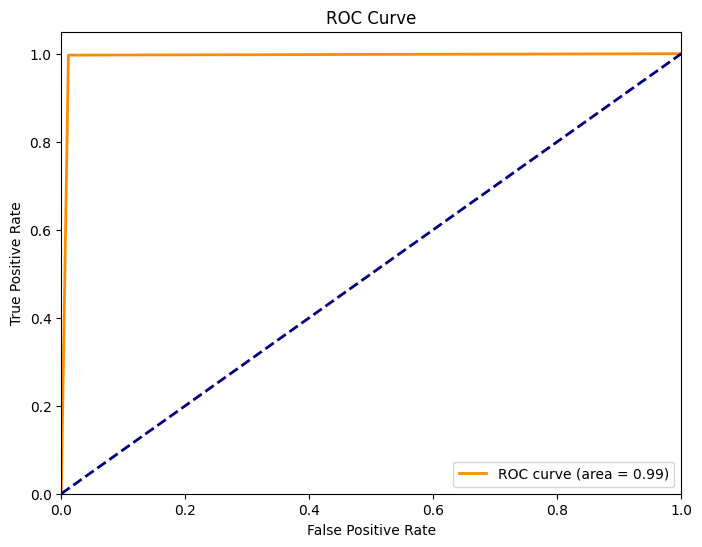

In [65]:

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test_val, y_pred)

# AUC score
roc_auc = roc_auc_score(y_test_val, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()